In [293]:
import cv2
import glob
import os
from matplotlib import pyplot as plt

## Brightness assesment algorithm

In [294]:
def create_colormap(path):
    avg = 0
    processed = 0
    for img_path in glob.iglob(f'{path}/*.JPG'):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([img], [2], None, [256], [0, 256])
        avg += hist
        processed += 1
    avg /= processed # normalization to one histogram
    cv2.normalize(avg,avg,0,255,cv2.NORM_MINMAX)
    return avg

# def create_colormap(path):
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     # [0, 1] - hue and saturation
#     hist = cv2.calcHist([img], [0, 1], None, [180, 256], [0, 180, 0, 256])
#     cv2.normalize(hist,hist,0,255,cv2.NORM_MINMAX)
#     return hist

def get_colormaps():
    light = create_colormap("./data/light")
    dark = create_colormap("./data/dark")
    normal = create_colormap("./data/normal")
    return light, dark, normal

def features_brightness(img_path):
    img = cv2.imread(img_path)
    cm_light, cm_dark, cm_normal = get_colormaps()
    rows,cols,_ = img.shape
    bp_light = cv2.calcBackProject([img], [2], cm_light, [0, 255], 1)
    bp_dark = cv2.calcBackProject([img], [2], cm_dark, [0, 255], 1)
    bp_normal = cv2.calcBackProject([img], [2], cm_normal, [0, 255], 1)
    cv2.normalize(bp_light, bp_light, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(bp_dark, bp_dark, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(bp_normal, bp_normal, 0, 255, cv2.NORM_MINMAX)
    CM1 = cv2.sumElems(bp_light)[0]/(rows*cols)
    CM2 = cv2.sumElems(bp_dark)[0]/(rows*cols)
    CM3 = cv2.sumElems(bp_normal)[0]/(rows*cols)
    return bp_light, bp_dark, bp_normal, CM1, CM2, CM3

The show_res_brightness function shows different stages and metrics of one image.

In [295]:
def show_res_brightness(img_path):
    im2, im3, im4, cm1, cm2, cm3 = features_brightness(img_path)
    im1 = cv2.imread(img_path)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)
    im3 = cv2.cvtColor(im3, cv2.COLOR_GRAY2RGB)
    im4 = cv2.cvtColor(im4, cv2.COLOR_GRAY2RGB)
    fig = plt.figure(figsize=(12, 10))
    fig.add_subplot(1, 4, 1)
    plt.imshow(im1)
    plt.axis('off') 
    plt.title("Původní obraz")
    fig.add_subplot(1, 4, 2)
    plt.imshow(im2)
    plt.axis('off') 
    plt.title("Zpětná projekce (světlé)")
    fig.add_subplot(1, 4, 3)
    plt.imshow(im3)
    plt.axis('off')
    plt.title("Zpětná projekce (tmavé)")
    fig.add_subplot(1, 4, 4)
    plt.imshow(im4)
    plt.axis('off')
    plt.title("Zpětná projekce (normální)")
    print("CM1: {:.2f}".format(cm1))
    print("CM2: {:.2f}".format(cm2))
    print("CM3: {:.2f}".format(cm3))


#### Examples of images

CM1: 63.31
CM2: 53.67
CM3: 53.62


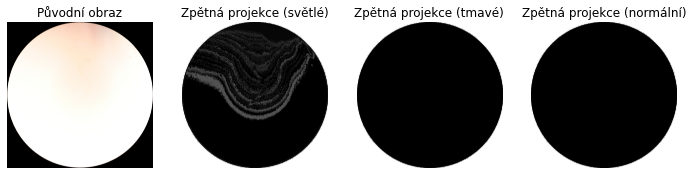

In [296]:
show_res_brightness("./data/light/012_F1_2642.JPG")

CM1: 54.89
CM2: 69.46
CM3: 55.38


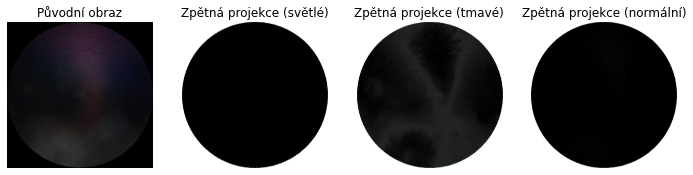

In [297]:
show_res_brightness("./data/dark/026_F1_2851.JPG")

CM1: 54.39
CM2: 55.55
CM3: 59.33


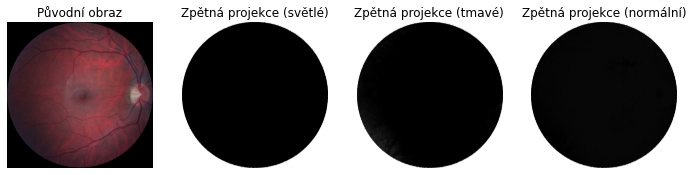

In [298]:
show_res_brightness("data/normal/046_R1_3103.JPG")

#### Algorithm validation

In [299]:
def validate_brightness(path):
    cm_light, cm_dark, cm_normal = get_colormaps()
    light = 0
    dark = 0
    normal = 0
    for img_path in glob.iglob(f'{path}/*.JPG'):
        _, _, _, cm1, cm2, cm3 = features_brightness(img_path)
        if cm1 > cm2 and cm1 > cm3:
            light += 1
        elif cm2 > cm1 and cm2 > cm3:
            dark += 1
        else:
            normal += 1
    return light, dark, normal

In [300]:
print("Light images validation:")
l, d, n = validate_brightness("./data/light")
print("Light: {}\nDark: {}\nNormal: {}".format(l, d, n))

print("Dark images validation:")
l, d, n = validate_brightness("./data/dark")
print("Light: {}\nDark: {}\nNormal: {}".format(l, d, n))

print("Normal images validation:")
l, d, n = validate_brightness("./data/normal")
print("Light: {}\nDark: {}\nNormal: {}".format(l, d, n))

Light images validation:


Light: 5
Dark: 0
Normal: 0
Dark images validation:
Light: 0
Dark: 2
Normal: 0
Normal images validation:
Light: 0
Dark: 0
Normal: 5


#### Dataset evaluation

In [301]:
def dataset_results_brightness(path):
    light = []
    light_cnt = 0
    dark = []
    dark_cnt = 0
    normal = []
    normal_cnt = 0
    for img_path in glob.iglob(f'{path}/*.JPG'):
        _, _, _, cm1, cm2, cm3 = features_brightness(img_path)
        if cm1 > cm2 and cm1 > cm3:
            light.append(img_path)
            light_cnt += 1
        elif cm2 > cm1 and cm2 > cm3:
            dark.append(img_path)
            dark_cnt += 1
        else:
            normal.append(img_path)
            normal_cnt += 1
    return light, light_cnt, dark, dark_cnt, normal, normal_cnt

In [302]:
light, light_cnt, dark, dark_cnt, normal, normal_cnt = dataset_results_brightness("./STRaDeSetA_preprocessed")
print("Light: {}\nDark: {}\nNormal: {}".format(light_cnt, dark_cnt, normal_cnt))
print("Light images: {}".format(light))
print("Dark images: {}".format(dark))

Light: 4
Dark: 50
Normal: 103
Light images: ['./STRaDeSetA_preprocessed/062_F1_2488.JPG', './STRaDeSetA_preprocessed/062_F2_2492.JPG', './STRaDeSetA_preprocessed/068_F1_2503.JPG', './STRaDeSetA_preprocessed/072_F1_2576.JPG']
Dark images: ['./STRaDeSetA_preprocessed/057_F2_2393.JPG', './STRaDeSetA_preprocessed/057_F3_2394.JPG', './STRaDeSetA_preprocessed/057_L3_2399.JPG', './STRaDeSetA_preprocessed/057_R3_2391.JPG', './STRaDeSetA_preprocessed/057_R6_2404.JPG', './STRaDeSetA_preprocessed/058_L2_2460.JPG', './STRaDeSetA_preprocessed/058_L3_2461.JPG', './STRaDeSetA_preprocessed/058_L4_2463.JPG', './STRaDeSetA_preprocessed/058_R1_2453.JPG', './STRaDeSetA_preprocessed/058_R2_2454.JPG', './STRaDeSetA_preprocessed/058_R4_2456.JPG', './STRaDeSetA_preprocessed/058_R6_2458.JPG', './STRaDeSetA_preprocessed/059_L3_2470.JPG', './STRaDeSetA_preprocessed/059_L4_2471.JPG', './STRaDeSetA_preprocessed/059_R3_2472.JPG', './STRaDeSetA_preprocessed/059_R4_2473.JPG', './STRaDeSetA_preprocessed/059_R5_2474.JP